In [1]:
import pandas as pd
import sklearn
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from time import time

# Check GPU

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

# Data overwiev

## Print shape of data

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
print("Image info :\n")
print("Number of images : ",len(x_train))
print("Image width : ",x_train[0].shape[0])
print("Image height : ",x_train[1].shape[1])

Image info :

Number of images :  60000
Image width :  28
Image height :  28


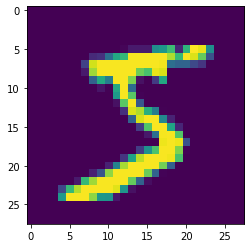

In [6]:
plt.imshow(x_train[0])

In [7]:
y_train[0]

5

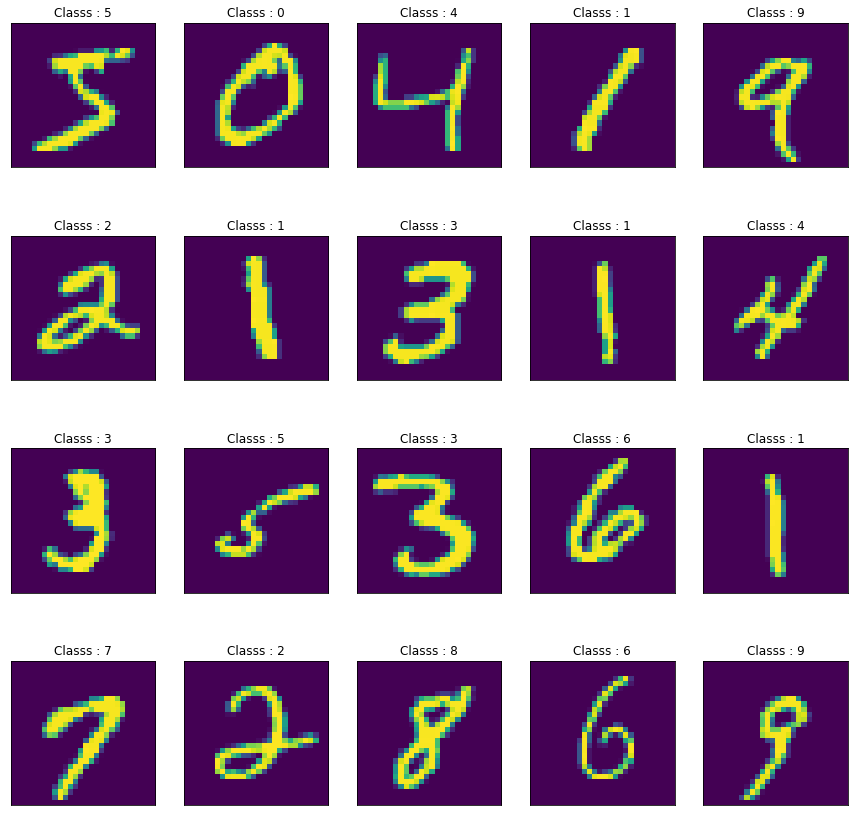

In [8]:
plt.figure(figsize=(15,15))
for i in range(20):
    ax = plt.subplot(4,5,i+1)
    plt.title("Classs : " + str(y_train[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_train[i])

# Build autoencoder

In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 8)           0   

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [13]:
import datetime
# set tensorboard
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [14]:
from keras.callbacks import TensorBoard

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[tensorboard_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 33s 552us/step - loss: 0.1494 - val_loss: 0.1417
Epoch 2/50
60000/60000 [==============================] - 32s 533us/step - loss: 0.1418 - val_loss: 0.1350
Epoch 3/50
60000/60000 [==============================] - 33s 553us/step - loss: 0.1370 - val_loss: 0.1352
Epoch 4/50
60000/60000 [==============================] - 33s 550us/step - loss: 0.1338 - val_loss: 0.1325
Epoch 5/50
60000/60000 [==============================] - 34s 570us/step - loss: 0.1303 - val_loss: 0.1271
Epoch 6/50
60000/60000 [==============================] - 32s 537us/step - loss: 0.1281 - val_loss: 0.1253
Epoch 7/50
60000/60000 [==============================] - 33s 544us/step - loss: 0.1262 - val_loss: 0.1250
Epoch 8/50
60000/60000 [==============================] - 33s 549us/step - loss: 0.1245 - val_loss: 0.1207
Epoch 9/50
60000/60000 [==============================] - 33s 545us/step - loss: 0.1223 - val_

# Let's take a look at the reconstructed digits:

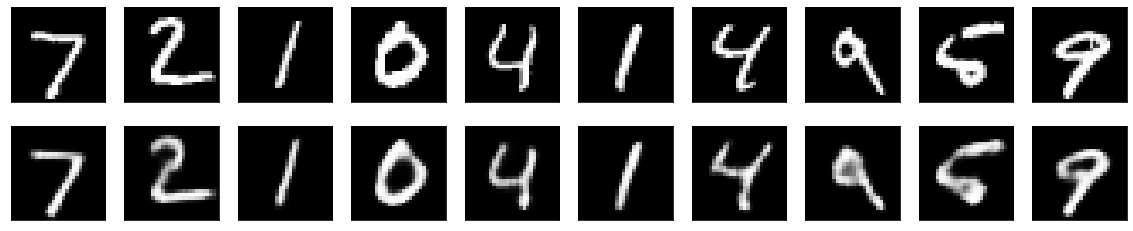

In [17]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [18]:
autoencoder.save("../models/autoencoder.h5")